# Feature Selection for Drug Overdose Data

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import patsy 
import math

pd.set_option('display.max_columns', 100)
%matplotlib inline

## Load CSV Files into Pandas DataFrames
The csv files are names as follows for each state:
* `{state}0.csv` - Introduction
* `{state}1.csv` - Outcomes & Factors Rankings
* `{state}2.csv` - Outcomes & Factors SubRankings
* `{state}3.csv` - Ranked Measure Data
* `{state}4.csv` - Additional Measure Data
* `{state}5.csv` - Ranked Measure Sources & Years
* `{state}6.csv` - Addtl Measure Sources & Years

The Additional Measure Data looks to contain the valuable information for this usecase.

In [2]:
states = ['alabama', 'florida', 'louisiana', 'nebraska', 'oklahoma', 'vermont', 'alaska', 
          'georgia', 'maine', 'nevada', 'oregon', 'virginia', 'arizona', 'hawaii', 
          'maryland', 'new-hampshire', 'pennsylvania', 'washington', 'arkansas', 'idaho',
          'massachusetts', 'new-jersey', 'rhode-island', 'west-virginia', 'california',
          'illinois', 'michigan', 'new-mexico', 'south-carolina', 'wisconsin', 'colorado',
          'indiana', 'minnesota', 'new-york', 'south-dakota', 'wyoming', 'connecticut', 
          'iowa', 'mississippi', 'north-carolina', 'tennessee', 'delaware', 'kansas',
          'missouri', 'north-dakota', 'texas', 'district-of-columbia', 'kentucky', 
          'montana', 'ohio', 'utah'
]

In [ ]:
measures = pd.DataFrame()
for state in states:
    data_path = 'data/csv/{}.csv.4'.format(state)
    measures = pd.concat([measures, pd.read_csv(data_path)])

Ranked Measure Data looks to add a few other interesting features 

In [3]:
ranked_measures = pd.DataFrame()
for state in states:
    data_path = 'data/csv/{}.csv.3'.format(state)
    

## Preliminary Data Cleaning

In [4]:
# Index by FIPS
measures = measures.set_index('FIPS')

In [5]:
# Confidence interval data and raw counts will not be used since %/rate are provided
measures = measures[[feature for feature in measures.columns if 'CI' not in feature]]
measures = measures[[feature for feature in measures.columns if '#' not in feature]]

In [6]:
# Examine how much data is missing for each feature
missing_counts = pd.DataFrame(measures.isna().sum())
missing_counts.columns = ['count']
missing_counts = missing_counts[missing_counts['count'] > 0]
missing_counts = missing_counts.sort_values(by='count')
missing_counts

,count
Household Income,1
% Uninsured.1,1
% Uninsured,1
% Rural,7
Costs,7
Range Drug Overdose Mortality Rate,8
% Limited Access,19
% Free or Reduced Lunch,20
Other PCP Ratio,35
Other PCP Rate,35


In [7]:
# We are focused on 'Drug Overdose Mortality Rate', if that is missing drop the county
measures = measures.dropna(subset=['Drug Overdose Mortality Rate'])

In [8]:
# There are just a handfull missing % Rural which is a key feature, examine it
measures[measures['% Rural'].isna()]

,State,County,Age-Adjusted Mortality,Age-Adjusted Mortality (Black),Age-Adjusted Mortality (Hispanic),Age-Adjusted Mortality (White),Child Mortality Rate,Child Mortality Rate (Black),Child Mortality Rate (Hispanic),Child Mortality Rate (White),Infant Mortality Rate,Infant Mortality Rate (Black),Infant Mortality Rate (Hispanic),Infant Mortality Rate (White),% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,HIV Prevalence Rate,% Food Insecure,% Limited Access,Drug Overdose Mortality Rate,Range Drug Overdose Mortality Rate,MV Mortality Rate,% Insufficient Sleep,% Uninsured,% Uninsured.1,Costs,Other PCP Rate,Other PCP Ratio,% Disconnected Youth,Household Income,Household income (Black),Household income (Hispanic),Household income (White),% Free or Reduced Lunch,Segregation index,Segregation Index,Homicide Rate,Firearm Fatalities Rate,Population,% < 18,% 65 and over,% African American,% American Indian/Alaskan Native,% Asian,% Native Hawaiian/Other Pacific Islander,% Hispanic,% Non-Hispanic White,% Not Proficient in English,% Female,% Rural
FIPS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [9]:
# The missing % Rural counties are clearly all very rural, assign 100% manually
measures['% Rural'] = measures['% Rural'].fillna(value=100)

In [10]:
# Create binary urban feature
measures['Urban'] = measures['% Rural'] <= 50

In [11]:
# Split out the statewate data measures and take into acount DC
statewide = measures[measures['County'].isnull()]
statewide = statewide.drop(statewide[statewide['State'] == 'District of Columbia'].index)

# Statewide rows lack certain features, remove them
statewide = statewide.dropna(axis='columns', how='all')

In [12]:
# Isolate the county level measures
counties = measures[measures['County'].notna()]

## Feature Examination
Look into feature quality and the presence of missing data in each feature

In [13]:
# If more than 75% of the Counties have missing data for a feature, prob not worth using
high_nan_features = []
for feature in counties.columns:
    percent_na = counties[feature].isna().sum() / len(counties)
    # Somewhat arbitrarily 75% missing, just seems very high
    if percent_na*100 > 75:
        print('{:.2%}'.format(percent_na), 'NaN:', feature)
        high_nan_features.append(feature)
counties = counties.drop(columns=high_nan_features)

78.61% NaN: Child Mortality Rate (Hispanic)
79.03% NaN: Infant Mortality Rate (Black)
86.22% NaN: Infant Mortality Rate (Hispanic)
75.71% NaN: Infant Mortality Rate (White)


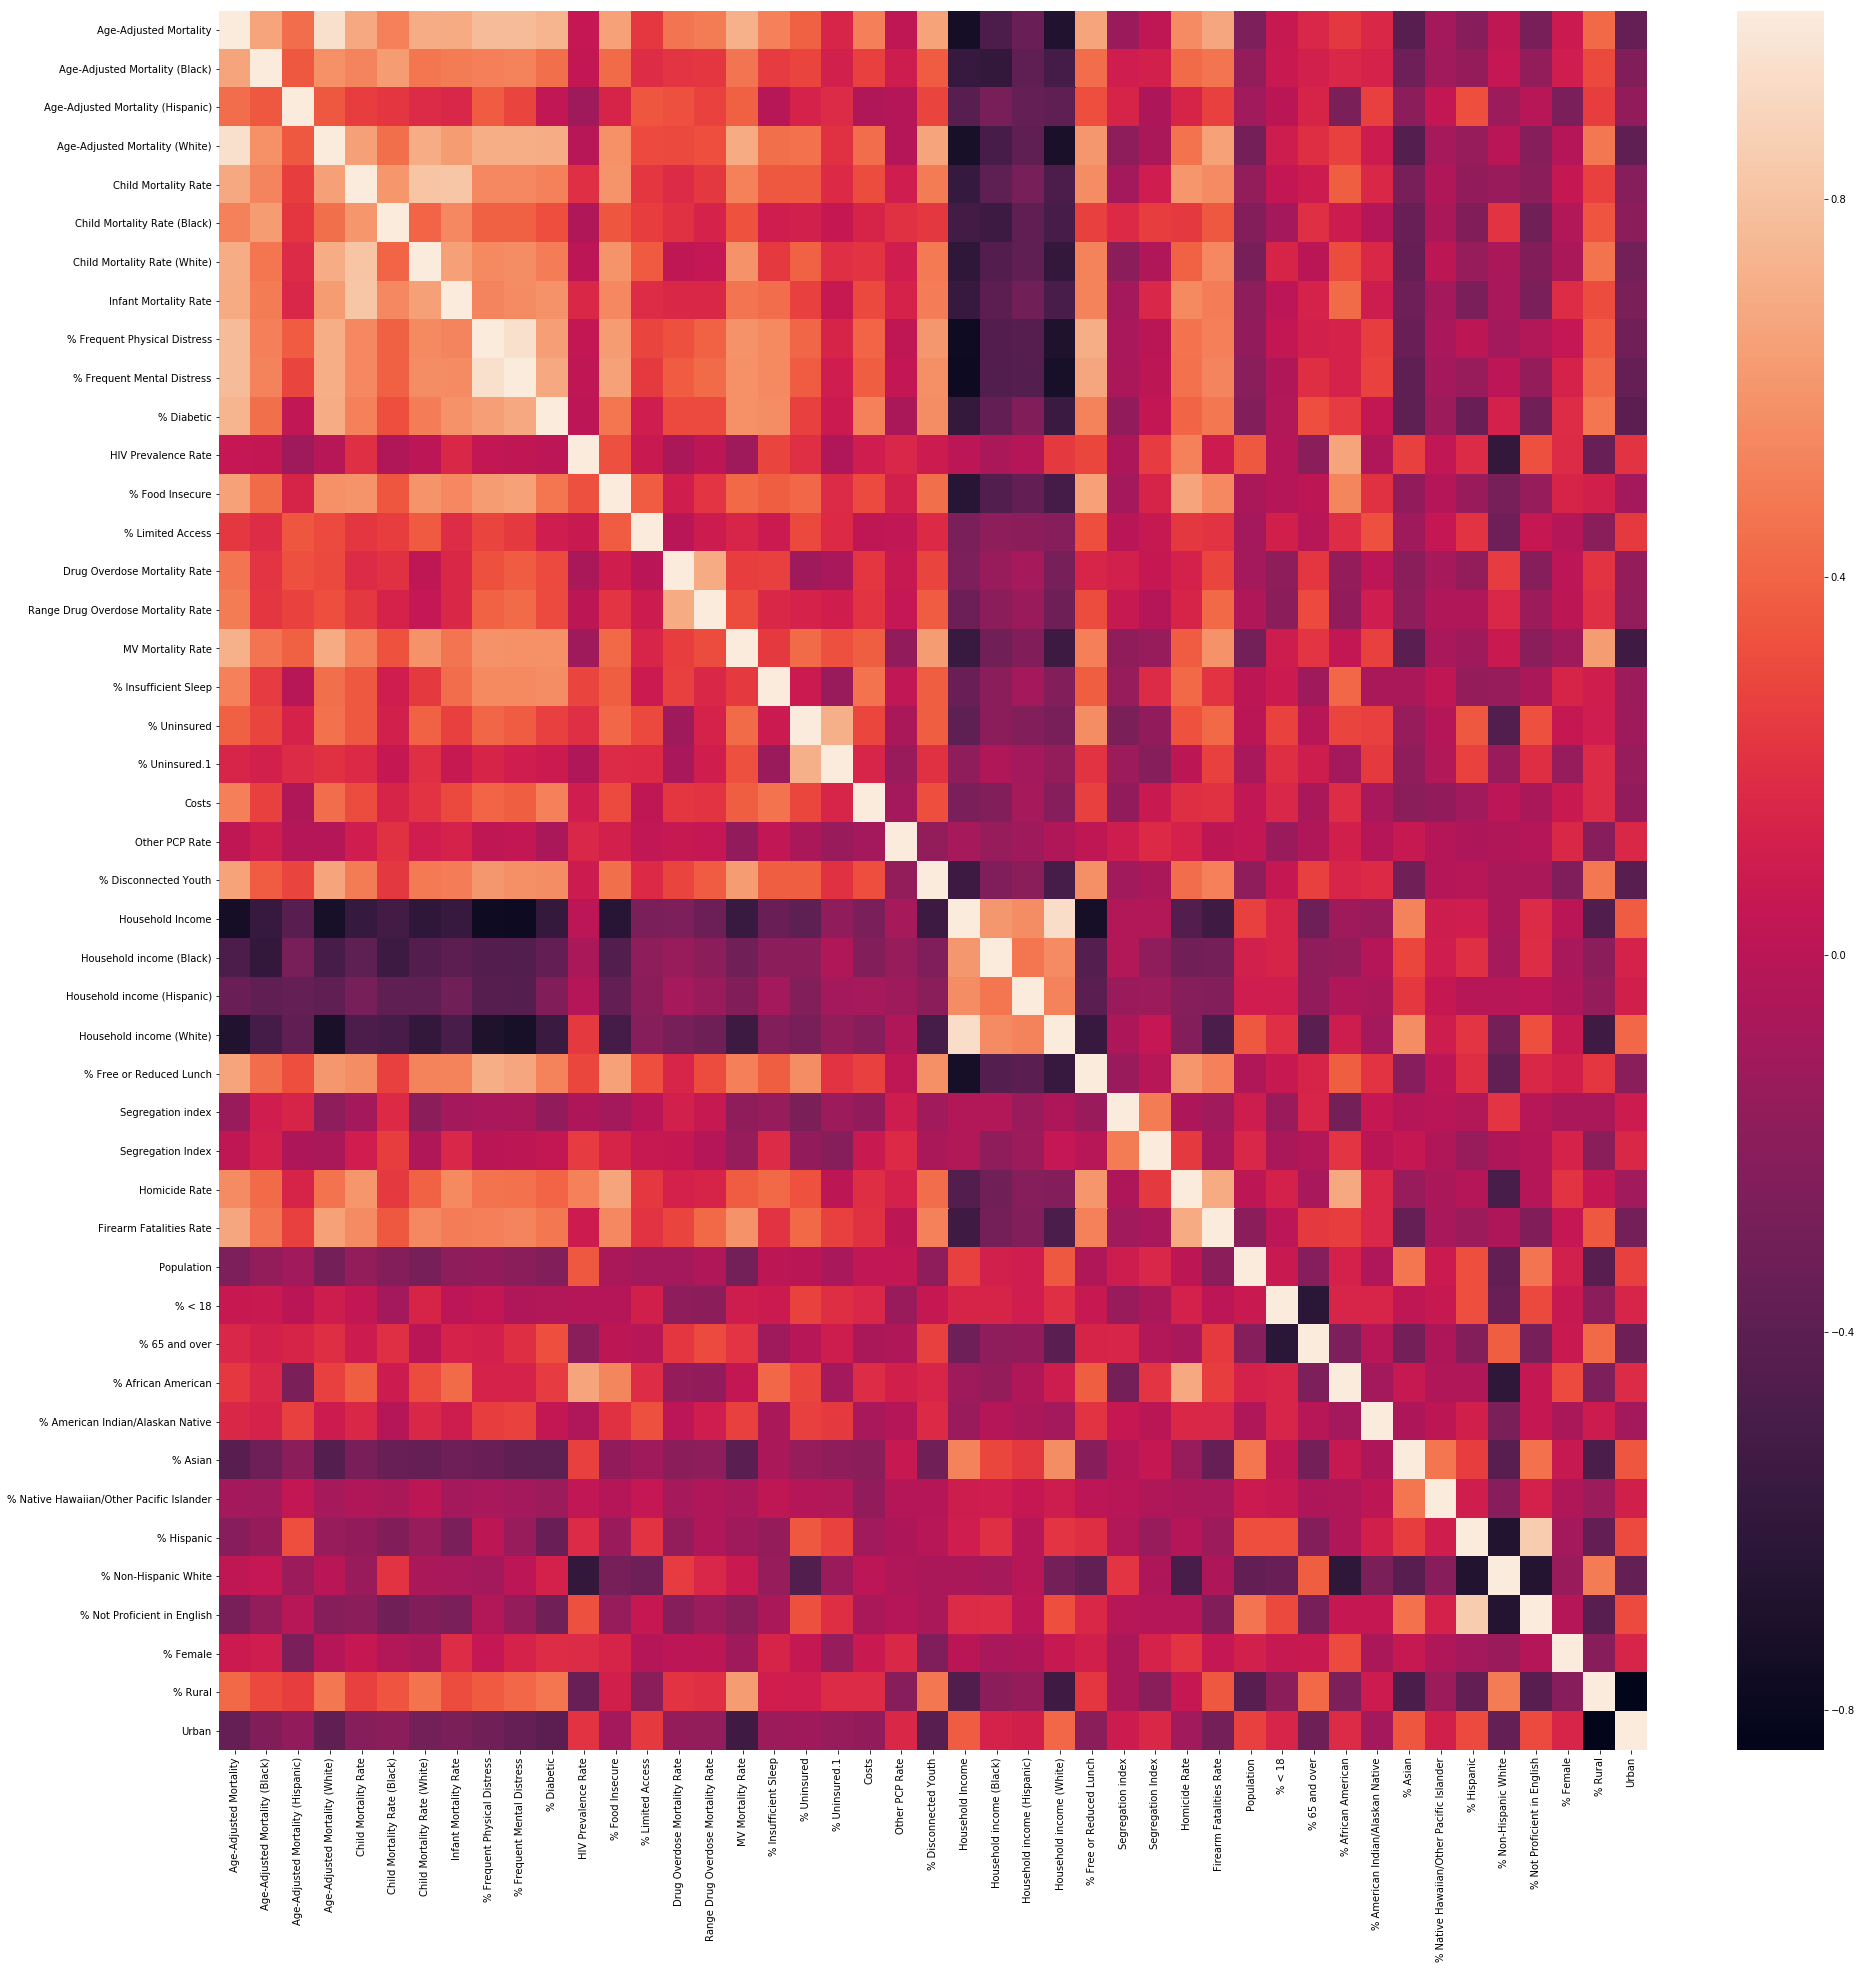

In [14]:
# Examine feature correlation using a heatmap
plt.figure(figsize=(32, 32))
sns.heatmap(data=counties.corr())
plt.show()

In [15]:
# 'Range Drug Overdose Mortality Rate' is a modeled rate and can be seen above
# to correlate strongly with actual, so we will use the actual only
counties = counties.drop(columns=['Range Drug Overdose Mortality Rate'])

In [16]:
# 'Other PCP Rate' and 'Other PCP Ratio' are redundant, rate is more useful
counties = counties.drop(columns=['Other PCP Ratio'])

### Impute Missing Values
Using a K-Nearest-Neighbors method, impute missing values for each feature with many missing values. The neighbors will be determined based on the columns with no missing data

In [17]:
# Look at which features are missing data
missing_counts = pd.DataFrame(counties.isna().sum())
missing_counts.columns = ['count']
missing_counts = missing_counts[missing_counts['count'] > 0]
missing_counts = missing_counts.sort_values(by='count')
missing_counts

,count
Costs,2
Other PCP Rate,2
Segregation Index,5
MV Mortality Rate,5
% Limited Access,10
% Free or Reduced Lunch,13
HIV Prevalence Rate,32
Firearm Fatalities Rate,49
Household income (White),68
% Disconnected Youth,134


In [18]:
# See the features without missing data
counties.columns[counties.notna().all()]

Index(['State', 'County', 'Age-Adjusted Mortality',
       '% Frequent Physical Distress', '% Frequent Mental Distress',
       '% Diabetic', '% Food Insecure', 'Drug Overdose Mortality Rate',
       '% Insufficient Sleep', '% Uninsured', '% Uninsured.1',
       'Household Income', 'Population', '% < 18', '% 65 and over',
       '% African American', '% American Indian/Alaskan Native', '% Asian',
       '% Native Hawaiian/Other Pacific Islander', '% Hispanic',
       '% Non-Hispanic White', '% Not Proficient in English', '% Female',
       '% Rural', 'Urban'],
      dtype='object')

In [19]:
# Choose which of those features to cluster on
# Subjective choice, also not including CI features or raw counts
impute_sources = ['% Frequent Physical Distress', '% Frequent Mental Distress',
       '% Diabetic', '% Food Insecure', '% Insufficient Sleep', 'Population', '% < 18',
       '% 65 and over', '% African American', '% American Indian/Alaskan Native',
       '% Asian', '% Native Hawaiian/Other Pacific Islander', '% Hispanic', 
       '% Non-Hispanic White', '% Not Proficient in English', '% Female', '% Rural']

In [20]:
# Fill in missing data using a K-Nearest-Neighbors approach
from sklearn.neighbors import KNeighborsRegressor 
def knn_imputer(df, sources, target, n_neighbors=5):
    X_train = (df[df[target].notna()])[sources]
    y_train = (df[df[target].notna()])[target]
    
    imp = KNeighborsRegressor(n_neighbors, weights='distance')
    imp.fit(X_train, y_train)
    imputed = imp.predict((df[df[target].isna()])[sources])
    
    res_df = df[df[target].isna()].copy()
    res_df[target] = imputed
    return res_df[[target]]

In [21]:
for feature in missing_counts.index.values:
    res_df = knn_imputer(counties, impute_sources, feature, 5)
    counties[feature] = counties[feature].fillna(value=res_df[feature].to_dict())

## 